In [21]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import SystemMessage, ToolMessage, BaseMessage, AIMessage
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, END
from langchain_ollama import ChatOllama

In [22]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [23]:
@tool
def add(num1: int, num2: int):
    """This function add two numbers together"""
    sum = num1 + num2
    return sum

In [24]:
@tool
def multiply(num1: int, num2: int):
    """This function multiply tow numbers together"""
    multiply = num1 * num2
    return multiply

In [25]:
tools = [add, multiply]

In [26]:
llm = ChatOllama(model = 'qwen2.5').bind_tools(tools)

In [27]:
def llm_node(state: AgentState) -> AgentState:
    print("\n\nSTATE: ", state)
    system_prompt = SystemMessage(["You are helfull assistant that answers the user's question accurately."])
    response = llm.invoke([system_prompt] + state["messages"])
    return {"messages": [response]}

In [28]:
def should_continue(state: AgentState) -> str:
    last_message = state["messages"][-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "tool_call"

In [29]:
graph = StateGraph(AgentState)
graph.add_node("llm", llm_node)

tool_node = ToolNode(tools = tools)
graph.add_node("tools", tool_node)

graph.set_entry_point("llm")
graph.add_conditional_edges(
    "llm",
    should_continue,
    {
        "tool_call": "tools",
        "end": END
    }
)

graph.add_edge("tools", "llm")
agent = graph.compile()

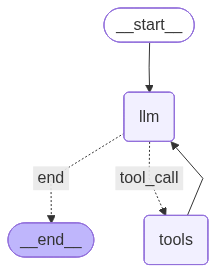

In [31]:
from IPython.display import display, Image
display(Image(agent.get_graph().draw_mermaid_png()))

In [32]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [33]:
inputs = {"messages": [("user", "Add 2 + 3. Multiply 3 * 2.")]}
print_stream(agent.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Add 2 + 3. Multiply 3 * 2.


STATE:  {'messages': [HumanMessage(content='Add 2 + 3. Multiply 3 * 2.', additional_kwargs={}, response_metadata={}, id='e8475d9a-f463-44a4-bd95-5dd6922239b8')]}
================================== Ai Message ==================================
Tool Calls:
  add (f3621f5e-0690-4373-b04b-353fa4d2fe79)
 Call ID: f3621f5e-0690-4373-b04b-353fa4d2fe79
  Args:
    num1: 2
    num2: 3
  multiply (ca4120a0-ad2e-4419-86ab-b0fe1a44bf80)
 Call ID: ca4120a0-ad2e-4419-86ab-b0fe1a44bf80
  Args:
    num1: 3
    num2: 2
================================= Tool Message =================================
Name: multiply

6


STATE:  {'messages': [HumanMessage(content='Add 2 + 3. Multiply 3 * 2.', additional_kwargs={}, response_metadata={}, id='e8475d9a-f463-44a4-bd95-5dd6922239b8'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5', 'created_at': '2026-01-11T15:13:33.7